# Experiment Template


**In this notebook:**

* Load original mri data + aneurysm mask
* Resample Images to 1.5 mm Voxelsize
* Filter images based on size
* Train network to predict vessel mask
* Evaluate aneurysm mask

**Todo:**
* Check percentage of 1s in resampled mask
* Write evaluation
* Try out different batch_sizes

## Dependencies
Install, load, and initialize all required dependencies for this experiment.

### Install Dependencies

In [3]:
#It should be possible to run the notebook independent of anything else. 
# If dependency cannot be installed via pip, either:
# - download & install it via %%bash
# - atleast mention those dependecies in this section

import sys
!{sys.executable} -m pip install -q -e ../../utils/


    ERROR: Command errored out with exit status 1:
     command: /opt/jupyterhub/bin/python3 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-02glc8l_/torch-scatter_1bd38de9738348cd870ba86fa835ffcf/setup.py'"'"'; __file__='"'"'/tmp/pip-install-02glc8l_/torch-scatter_1bd38de9738348cd870ba86fa835ffcf/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-5hwbniwo
         cwd: /tmp/pip-install-02glc8l_/torch-scatter_1bd38de9738348cd870ba86fa835ffcf/
    Complete output (5 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-install-02glc8l_/torch-scatter_1bd38de9738348cd870ba86fa835ffcf/setup.py", line 8, in <module>
        import torch
    M

In [4]:
!{sys.executable} -m pip install tqdm


  Using cached tqdm-4.61.1-py2.py3-none-any.whl (75 kB)
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/opt/jupyterhub/lib/python3.6/site-packages/tqdm'
Check the permissions.

You should consider upgrading via the '/opt/jupyterhub/bin/python3 -m pip install --upgrade pip' command.


### Import Dependencies

# System libraries

In [62]:
from __future__ import absolute_import, division, print_function
import logging, os, sys

# Enable logging
logging.basicConfig(format='[%(levelname)s] %(message)s', level=logging.INFO, stream=sys.stdout)

# Re-import packages if they change
%load_ext autoreload
%autoreload 2

# Recursion Depth
import sys
sys.setrecursionlimit(10000)

# Intialize tqdm to always use the notebook progress bar
import tqdm
tqdm.tqdm = tqdm.tqdm_notebook

# Third-party libraries
import comet_ml
import numpy as np
import pandas as pd
import nilearn.plotting as nip
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import collections
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)
%config InlineBackend.figure_format='retina'  # adapt plots for retina displays
import git


# Project utils

import aneurysm_utils
from aneurysm_utils import evaluation, training


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
if "workspace" in os.getcwd():
    ROOT = "/workspace"
elif "/group/cake" in os.getcwd(): 
    ROOT = "/group/cake"


### Initialize Environment

In [64]:
env = aneurysm_utils.Environment(project="our-git-project", root_folder=ROOT)
env.cached_data["comet_key"] = "EGrR4luSis87yhHbs2rEaqAWs" 
env.print_info()

Environment Info:

Library Version: 0.1.0
Configured Project: our-git-project

Folder Structure: 
- Root folder: /group/cake
 - Project folder: /group/cake/our-git-project
 - Datasets folder: /data/training
 - Models folder: /group/cake/our-git-project/models
 - Experiments folder: /group/cake/our-git-project/experiments


## Load Data
Download, explore, and prepare all required data for the experiment in this section.

In [79]:
dataset_params = {
    "prediction": "mask",
    "mri_data_selection": "", 
    "balance_data": False,
    "seed": 1,
    "resample_voxel_dim": (2.0, 2.0, 2.0)
}

preprocessing_params = {
    'min_max_normalize': True,
    'mean_std_normalize': False,
    'smooth_img': False, # can contain a number: smoothing factor
    'intensity_segmentation': 0.35
}


### Load Meta Data

In [80]:
from aneurysm_utils.data_collection import load_aneurysm_dataset

df = load_aneurysm_dataset(
    env,
    mri_data_selection=dataset_params["mri_data_selection"],
    random_state=dataset_params["seed"]
)
df.head()

Aneurysm Geometry  Angiography Data  Vessel Geometry  Labeled Mask Index  \
0          A001.stl  A001_orig.nii.gz  A001_vessel.stl                   1   
1          A003.stl  A003_orig.nii.gz  A003_vessel.stl                   1   
2          A005.stl  A005_orig.nii.gz  A005_vessel.stl                   1   
3          A006.stl  A006_orig.nii.gz  A006_vessel.stl                   1   
4          A008.stl  A008_orig.nii.gz  A008_vessel.stl                   1   

  Location  Age Sex  Rupture Status   Age Bin  Aneurysm Count  Case  \
0     Acom   48   m             1.0  (40, 50]               1  A001   
1     Pcom   58   f             0.0  (50, 60]               1  A003   
2     PICA   45   m             1.0  (40, 50]               1  A005   
3     ACom   46   f             1.0  (40, 50]               1  A006   
4      ACA   72   f             0.0  (70, 80]               1  A008   

                         Path Orig                         Path Mask  \
0  /data/training/A001_orig.nii.gz  /data/training/A001_masks.nii.gz   
1  /data/training/A003_orig.nii.gz  /data/training/A003_masks.nii.gz   
2  /data/training/A005_orig.nii.gz  /data/training/A005_masks.nii.gz   
3  /data/training/A006_orig.nii.gz  /data/training/A006_masks.nii.gz   
4  /data/training/A008_orig.nii.gz  /data/training/A008_masks.nii.gz   

                         Path Vessel                        Path Labeled Mask  
0  /data/training/A001_vessel.nii.gz  /data/training/A001_labeledMasks.nii.gz  
1  /data/training/A003_vessel.nii.gz  /data/training/A003_labeledMasks.nii.gz  
2  /data/training/A005_vessel.nii.gz  /data/training/A005_labeledMasks.nii.gz  
3  /data/training/A006_vessel.nii.gz  /data/training/A006_labeledMasks.nii.gz  
4  /data/training/A008_vessel.nii.gz  /data/training/A008_labeledMasks.nii.gz

### Load & Split MRI Data

In [82]:
# Load MRI images and split into train, test, and validation
from aneurysm_utils.data_collection import split_mri_images
# case_list = ["A009","A010","A012","A013","A014","A015"]
# df = df.loc[df["Case"].isin(case_list)]

train_data, test_data, val_data, _ = split_mri_images(
    env, 
    df, 
    prediction=dataset_params["prediction"], 
    encode_labels=False,
    random_state=dataset_params["seed"],
    balance_data=dataset_params["balance_data"],
    resample_voxel_dim=dataset_params["resample_voxel_dim"]
)

mri_imgs_train, labels_train = train_data
mri_imgs_test, labels_test = test_data
mri_imgs_val, labels_val = val_data

109
98
         Images
-----  --------
All         109
Train        87
Val          11
Test         11



  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [83]:
from aneurysm_utils import preprocessing

most_common_shape=preprocessing.check_mri_shapes(mri_imgs_train)

print(most_common_shape)

Most common:
(70, 70, 60):      80
(35, 35, 31):       2
(36, 36, 30):       2
(55, 55, 49):       2
(36, 36, 31):       1
(70, 70, 60)


## Transform & Preprocess Data

In [84]:
from aneurysm_utils import preprocessing

size_of_train = len(mri_imgs_train)
size_of_test = len(mri_imgs_test)
size_of_val = len(mri_imgs_val)

# preprocess all lists as one to have a working mean_std_normalization
mri_imgs = mri_imgs_train + mri_imgs_test + mri_imgs_val
mri_imgs = preprocessing.preprocess(env, mri_imgs, preprocessing_params)

mri_imgs_train = mri_imgs[:size_of_train]
mri_imgs_train = [train for train in mri_imgs_train]
mri_imgs_test = mri_imgs[size_of_train : size_of_train + size_of_test]
mri_imgs_test = [test for test in mri_imgs_test]
mri_imgs_val = mri_imgs[size_of_train + size_of_test :]
mri_imgs_val = [val for val in mri_imgs_val]

# preprocess mask
x, y, h = labels_train[0].shape
labels_train = [label_train for label_train in labels_train]
labels_test = [label_test for label_test in labels_test]
labels_val = [label_val for label_val in labels_val]
# flatten

[INFO] Preprocessing: Min Max Normalize...
[INFO] Preprocessing: Intensity Segmentation...


In [85]:
size =(70,70,60)#(139, 139, 120)#(47,47,41)#
print(size)
train_index = [i for i, e in enumerate(mri_imgs_train) if e.shape != size]
mri_imgs_train = [i for j, i in enumerate(mri_imgs_train) if j not in train_index]
labels_train = [i for j, i in enumerate(labels_train) if j not in train_index]

test_index = [i for i, e in enumerate(mri_imgs_test) if e.shape != size]
mri_imgs_test = [i for j, i in enumerate(mri_imgs_test) if j not in test_index]
labels_test = [i for j, i in enumerate(labels_test) if j not in test_index]

val_index = [i for i, e in enumerate(mri_imgs_val) if e.shape != size]
mri_imgs_val = [i for j, i in enumerate(mri_imgs_val) if j not in val_index]
labels_val = [i for j, i in enumerate(labels_val) if j not in val_index]

mri_imgs_train[0].shape
preprocessing.check_mri_shapes(mri_imgs_train)
print(np.unique(labels_val[0], return_counts=True))


(70, 70, 60)
Most common:
(70, 70, 60):      80
(array([0., 1.], dtype=float32), array([293988,     12]))


### Optional: View image


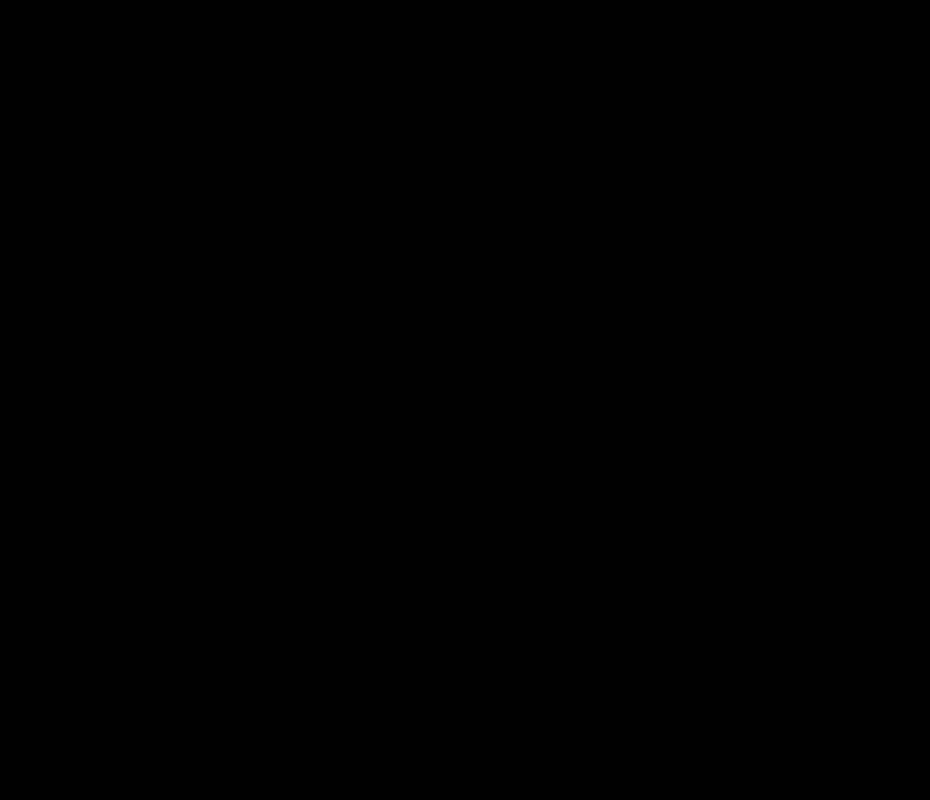
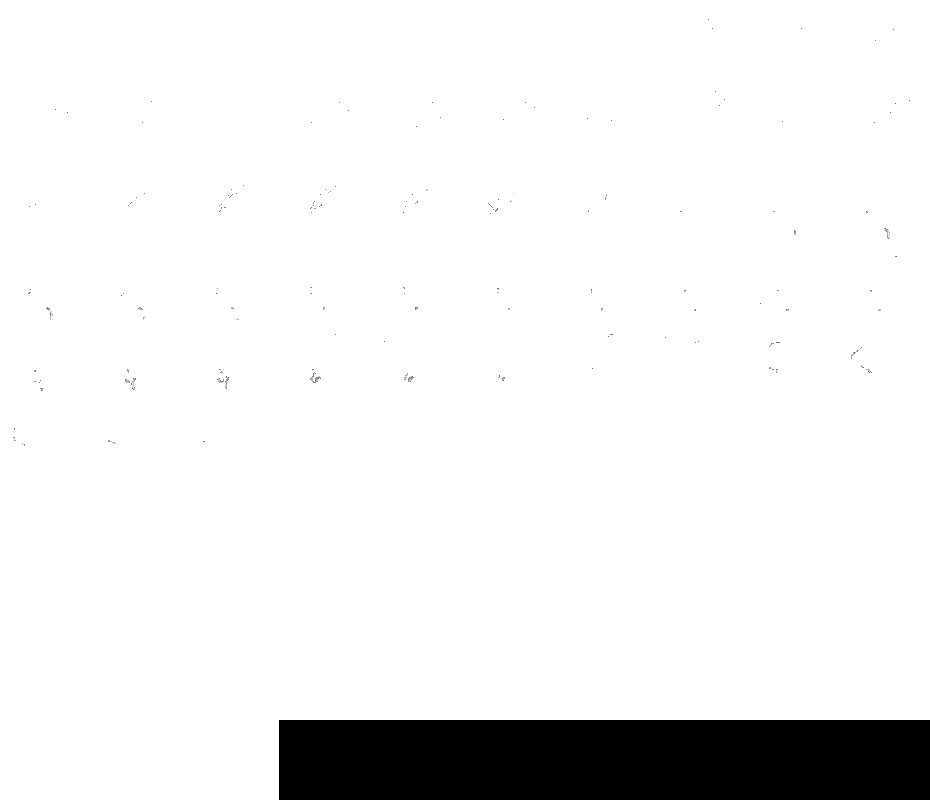

In [14]:
idx = 0
nip.view_img(
    nib.Nifti1Image(mri_imgs_train[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

In [ ]:
evaluation.plot_slices(mri_imgs_train[0])

## Train Model
Implementation, configuration, and evaluation of the experiment.

### Train Deep Model 3D data

In [90]:
from comet_ml import Optimizer

artifacts = {
    "train_data": (mri_imgs_train, labels_train),
    "val_data": (mri_imgs_val, labels_val),
    "test_data": (mri_imgs_test, labels_test)
}

# Define parameter configuration for experiment run
# params = {
#     "batch_size": 3,
#     "epochs": 10,
#     "es_patience": None, # None = deactivate early stopping
#     "model_name": 'SegNet',
#     "optimizer_momentum": 0.9,
#     "optimizer":'Adam',
#     "learning_rate": 0.0001,
#     "criterion": "CrossEntropyLoss",
#     "sampler": None,   #'ImbalancedDatasetSampler2',
#     "shuffle_train_set": True,
#     "save_models": False,
#     "criterion_weights": [1.0, 1000.0],
#     "debug": True,
#     "weight_decay":0.01
# }
params = {
    "batch_size": 32,
    "epochs": 3000,
    "learning_rate": 2.6e-5, # 3e-04, 1.0E-5
    "es_patience": None, # None = deactivate early stopping
    "weight_decay": 0.000003, # 1e-3
    "model_name": 'SegNet',
    "optimizer_momentum": 0.9,
    "optimizer":'Adam',
    "criterion": "CrossEntropyLoss", 
    "criterion_weights": [1.0, 30.0], # [1.75, 1.0],
    "sampler": None,   #'ImbalancedDatasetSampler2',
    "shuffle_train_set": True,
    "scheduler": None,#"ReduceLROnPlateau", # "ReduceLROnP
    "debug":False,
    "dropout":0.38,
    "start_radius":0.2*int(most_common_shape[0]),
    "sample_rate1":0.2,
    "sample_rate2":0.25
    
}
params.update(dataset_params)
params.update(preprocessing_params)
config = {
    # We pick the Bayes algorithm:
    "algorithm": "bayes",
    # Declare your hyperparameters in the Vizier-inspired format:
    "parameters": {
#         "criterion_weights": {"type": "integer", "scalingType": "loguniform", "min": 1, "max": 10000},
#         "weight_decay": {"type": "float", "scalingType": "loguniform", "min": 1e-10, "max": 1e-3},
#         "learning_rate": {"type": "float", "scalingType": "loguniform", "min": 1e-10, "max": 1e2},
#         "scheduler": {"type": "categorical", "values": ["ReduceLROnPlateau", ""]},
#         "dropout":{"type":"float","scalingType":"loguniform","min":0.1,"max":0.5},
        "start_radius":{"type":"float","scalingType":"loguniform","min":0.1*int(most_common_shape[0]),"max":0.25*int(most_common_shape[0])},
        "sample_rate1":{"type":"float","scalingType":"loguniform","min":0.1,"max":0.3},
        "sample_rate2":{"type":"float","scalingType":"loguniform","min":0.1,"max":0.3}
    },
    # Declare what we will be optimizing, and how:
    "spec": {"metric": "validate_bal_acc", "objective": "maximize"},  #test balance accuracy
}


opt = Optimizer(config, api_key=env.cached_data["comet_key"])

COMET INFO: COMET_OPTIMIZER_ID=1a909f72194b4415ac51b278aa4d4630
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 'infinite', 'endTime': None, 'id': '1a909f72194b4415ac51b278aa4d4630', 'lastUpdateTime': None, 'maxCombo': 0, 'name': '1a909f72194b4415ac51b278aa4d4630', 'parameters': {'sample_rate1': {'max': 0.3, 'min': 0.1, 'scalingType': 'loguniform', 'type': 'float'}, 'sample_rate2': {'max': 0.3, 'min': 0.1, 'scalingType': 'loguniform', 'type': 'float'}, 'start_radius': {'max': 17.5, 'min': 7.0, 'scalingType': 'loguniform', 'type': 'float'}}, 'predictor': None, 'spec': {'gridSize': 10, 'maxCombo': 0, 'metric': 'validate_bal_acc', 'minSampleSize': 100, 'objective': 'maximize', 'retryAssignLimit': 0, 'retryLimit': 1000}, 'startTime': 12935130030, 'state': {'mode': None, 'seed': None, 'sequence': [], 'sequence_i': 0, 'sequence_pid': None, 'sequence_retry': 0, 'sequence_retry_count': 0}, 'status': 'running', 'suggestion_count': 0, 'trials': 1, 'version': '2.0.1'

In [ ]:
# Finally, get experiments, and train your models:
for comet_exp in opt.get_experiments(project_name=env.project+ "-" + params["prediction"]):
    print(comet_exp)
    param_copy = params.copy()
    comet_exp.params
    for key in config["parameters"].keys():
        param_copy[key]=comet_exp.get_parameter(key)
        print(param_copy[key])
#     param_copy["weight_decay"] = comet_exp.get_parameter("weight_decay")
#     param_copy["criterion_weights"] = comet_exp.get_parameter("criterion_weights")
#     param_copy["learning_rate"] = comet_exp.get_parameter("learning_rate")
#     param_copy["scheduler"] = comet_exp.get_parameter("scheduler")

    exp = env.create_experiment(
        params["prediction"] + "-pytorch-" + params["model_name"], comet_exp
    ) #params["selected_label"] + "-hyperopt-" + params["model_name"]
    exp.run(training.train_pytorch_model, param_copy, artifacts)


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/1c5caba9b534441c839d8f4c4154916e



10.799347927349237
0.11077489995906759
0.2370599766611839
[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-06-20-14-29-33_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 80
[INFO] Validation dataset loaded. Length: 11
[INFO] Engine run starting with max_epochs=3000.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.70
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.70
[INFO] Epoch[1] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engin

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Training Results - Epoch: 1589 Bal Avg accuracy: 0.95 Avg loss: 0.26
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1589 Bal Avg accuracy: 0.53 Avg loss: 3.70
[INFO] Epoch[1589] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1590 Bal Avg accuracy: 0.96 Avg loss: 0.09
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1590 Bal Avg accuracy: 0.56 Avg loss: 3.35
[INFO] Epoch[1590] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Validation Results - Epoch: 2487 Bal Avg accuracy: 0.55 Avg loss: 4.81
[INFO] Epoch[2487] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2488 Bal Avg accuracy: 0.97 Avg loss: 0.05
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2488 Bal Avg accuracy: 0.51 Avg loss: 5.84
[INFO] Epoch[2488] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2489 Bal Avg accuracy: 0.97 Avg loss: 0.07
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Result

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Epoch[390] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 391 Bal Avg accuracy: 0.97 Avg loss: 0.09
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 391 Bal Avg accuracy: 0.55 Avg loss: 2.49
[INFO] Epoch[391] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 392 Bal Avg accuracy: 0.97 Avg loss: 0.14
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 392 Bal Avg accuracy: 0.59 Avg loss: 2.30
[INFO] Epoch[392] Complete. Ti

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1349 Bal Avg accuracy: 0.53 Avg loss: 4.52
[INFO] Epoch[1349] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1350 Bal Avg accuracy: 0.98 Avg loss: 0.06
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1350 Bal Avg accuracy: 0.60 Avg loss: 4.13
[INFO] Epoch[1350] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1351 Bal Avg accuracy: 0.98 Avg loss: 0.04
[INFO] Engine run starti

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2276 Bal Avg accuracy: 0.99 Avg loss: 0.03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2276 Bal Avg accuracy: 0.54 Avg loss: 5.41
[INFO] Epoch[2276] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2277 Bal Avg accuracy: 0.99 Avg loss: 0.03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2277 Bal Avg accuracy: 0.53 Avg loss: 5.17
[INFO] Epoch[2277] Complete. Time taken: 00:00:02
[INFO] Engine run starti

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 268 Bal Avg accuracy: 0.55 Avg loss: 2.05
[INFO] Epoch[268] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 269 Bal Avg accuracy: 0.94 Avg loss: 0.16
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 269 Bal Avg accuracy: 0.59 Avg loss: 2.02
[INFO] Epoch[269] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 270 Bal Avg accuracy: 0.96 Avg loss: 0.11
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Ti

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1198 Bal Avg accuracy: 0.96 Avg loss: 0.28
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1198 Bal Avg accuracy: 0.53 Avg loss: 4.38
[INFO] Epoch[1198] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1199 Bal Avg accuracy: 0.96 Avg loss: 0.40
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1199 Bal Avg accuracy: 0.53 Avg loss: 4.43
[INFO] Epoch[1199] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run comple

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2184 Bal Avg accuracy: 0.52 Avg loss: 5.47
[INFO] Epoch[2184] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2185 Bal Avg accuracy: 0.98 Avg loss: 0.07
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2185 Bal Avg accuracy: 0.51 Avg loss: 5.47
[INFO] Epoch[2185] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2186 Bal Avg accuracy: 0.98 Avg loss: 0.05
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run comple

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Epoch[155] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 156 Bal Avg accuracy: 0.91 Avg loss: 0.18
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 156 Bal Avg accuracy: 0.60 Avg loss: 0.77
[INFO] Epoch[156] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 157 Bal Avg accuracy: 0.90 Avg loss: 0.26
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 157 Bal Avg accuracy: 0.67 Avg loss: 0.59
[INFO] Epoch[157] Complete. Ti

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Training Results - Epoch: 1124 Bal Avg accuracy: 0.98 Avg loss: 0.05
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1124 Bal Avg accuracy: 0.63 Avg loss: 2.22
[INFO] Epoch[1124] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1125 Bal Avg accuracy: 0.98 Avg loss: 0.04
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1125 Bal Avg accuracy: 0.68 Avg loss: 1.81
[INFO] Epoch[1125] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2097 Bal Avg accuracy: 0.64 Avg loss: 3.02
[INFO] Epoch[2097] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2098 Bal Avg accuracy: 0.98 Avg loss: 0.06
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2098 Bal Avg accuracy: 0.53 Avg loss: 3.47
[INFO] Epoch[2098] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2099 Bal Avg accuracy: 0.98 Avg loss: 0.04
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy (): 0.9998892668178383
Balanced Accuracy (): 0.5437162196287323
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2645737
         1.0       0.30      0.09      0.14       263

    accuracy                           1.00   2646000
   macro avg       0.65      0.54      0.57   2646000
weighted avg       1.00      1.00      1.00   2646000



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rbendias/our-git-project-mask/aa2973ab39d54e788dea2bca35888f72
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [901]               : (0.016999991610646248, 0.7445287108421326)
COMET INFO:     test_accuracy            : 0.9998892668178383
COMET INFO:     test_bal_acc             : 0.5437162196287323
COMET INFO:     test_f1                  : 0.13569321533923304
COMET INFO:     test_precision           : 0.3026315789473684
COMET INFO:     test_recall              : 0.08745247148288973
COMET INFO:     test_sen                 : 0.08745247148288973
COMET INFO:     test_spec                : 0.9999799677745748
COMET INFO:     train_accuracy [3000]    : (0.2958427328391879, 0.9837075231854477)
COMET INFO:     train_avg_loss [3000]    : (0

[INFO] Experiment run completed: mask-pytorch-SegNet. Duration: 2 hours 1 minutes 38 seconds


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/af72f4d2a3be443e93b9170cea7743af



8.592976879830513
0.17833972412904903
0.15832631079903095
[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-06-20-22-35-23_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 80
[INFO] Validation dataset loaded. Length: 11
[INFO] Engine run starting with max_epochs=3000.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.70
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.70
[INFO] Epoch[1] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engin

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1150 Bal Avg accuracy: 0.98 Avg loss: 0.05
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1150 Bal Avg accuracy: 0.59 Avg loss: 3.70
[INFO] Epoch[1150] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1151 Bal Avg accuracy: 0.98 Avg loss: 0.14
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1151 Bal Avg accuracy: 0.60 Avg loss: 3.39
[INFO] Epoch[1151] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2149 Bal Avg accuracy: 0.54 Avg loss: 6.00
[INFO] Epoch[2149] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2150 Bal Avg accuracy: 0.98 Avg loss: 0.04
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2150 Bal Avg accuracy: 0.53 Avg loss: 5.18
[INFO] Epoch[2150] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2151 Bal Avg accuracy: 0.99 Avg loss: 0.03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run comple

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 90 Bal Avg accuracy: 0.55 Avg loss: 0.95
[INFO] Epoch[90] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 91 Bal Avg accuracy: 0.86 Avg loss: 0.26
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 91 Bal Avg accuracy: 0.55 Avg loss: 1.27
[INFO] Epoch[91] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 92 Bal Avg accuracy: 0.86 Avg loss: 0.25
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Epoch[1088] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1089 Bal Avg accuracy: 0.96 Avg loss: 0.13
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1089 Bal Avg accuracy: 0.53 Avg loss: 4.18
[INFO] Epoch[1089] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1090 Bal Avg accuracy: 0.97 Avg loss: 0.07
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1090 Bal Avg accuracy: 0.58 Avg loss: 4.60
[INFO] Epoch[1090] Compl

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1925 Bal Avg accuracy: 0.96 Avg loss: 0.11
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1925 Bal Avg accuracy: 0.56 Avg loss: 4.73
[INFO] Epoch[1925] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1926 Bal Avg accuracy: 0.95 Avg loss: 0.49
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1926 Bal Avg accuracy: 0.62 Avg loss: 4.91
[INFO] Epoch[1926] Complete. Time taken: 00:00:03
[INFO] Engine run starti

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2880 Bal Avg accuracy: 0.96 Avg loss: 0.13
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2880 Bal Avg accuracy: 0.51 Avg loss: 6.73
[INFO] Epoch[2880] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2881 Bal Avg accuracy: 0.96 Avg loss: 0.12
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2881 Bal Avg accuracy: 0.54 Avg loss: 6.09
[INFO] Epoch[2881] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy (): 0.9998945578231293
Balanced Accuracy (): 0.5589264790035697
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2645737
         1.0       0.40      0.12      0.18       263

    accuracy                           1.00   2646000
   macro avg       0.70      0.56      0.59   2646000
weighted avg       1.00      1.00      1.00   2646000



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rbendias/our-git-project-mask/2bd615cd79df4153907cb3a20d447ac9
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [901]               : (0.021385788917541504, 0.7621905207633972)
COMET INFO:     test_accuracy            : 0.9998945578231293
COMET INFO:     test_bal_acc             : 0.5589264790035697
COMET INFO:     test_f1                  : 0.18181818181818182
COMET INFO:     test_precision           : 0.3974358974358974
COMET INFO:     test_recall              : 0.11787072243346007
COMET INFO:     test_sen                 : 0.11787072243346007
COMET INFO:     test_spec                : 0.9999822355736795
COMET INFO:     train_accuracy [3000]    : (0.3306477602320335, 0.9764027643499122)
COMET INFO:     train_avg_loss [3000]    : (0

[INFO] Experiment run completed: mask-pytorch-SegNet. Duration: 2 hours 9 minutes 6 seconds


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/9526edbc71e340cf8798c9a423367d85



7.682142157235732
0.10372209038760004
0.15694972539743876
[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-06-21-02-48-33_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 80
[INFO] Validation dataset loaded. Length: 11
[INFO] Engine run starting with max_epochs=3000.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.70
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.70
[INFO] Epoch[1] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engin

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 880 Bal Avg accuracy: 0.60 Avg loss: 1.67
[INFO] Epoch[880] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 881 Bal Avg accuracy: 0.93 Avg loss: 0.30
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 881 Bal Avg accuracy: 0.64 Avg loss: 1.36
[INFO] Epoch[881] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 882 Bal Avg accuracy: 0.92 Avg loss: 0.26
[INFO] Engine run starting wit

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1872 Bal Avg accuracy: 0.96 Avg loss: 0.11
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1872 Bal Avg accuracy: 0.67 Avg loss: 1.72
[INFO] Epoch[1872] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1873 Bal Avg accuracy: 0.95 Avg loss: 0.57
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1873 Bal Avg accuracy: 0.67 Avg loss: 1.80
[INFO] Epoch[1873] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2853 Bal Avg accuracy: 0.97 Avg loss: 0.07
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2853 Bal Avg accuracy: 0.62 Avg loss: 3.37
[INFO] Epoch[2853] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2854 Bal Avg accuracy: 0.94 Avg loss: 1.09
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2854 Bal Avg accuracy: 0.51 Avg loss: 3.39
[INFO] Epoch[2854] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run comple

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy (): 0.9998745275888133
Balanced Accuracy (): 0.6273507241323262
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2645737
         1.0       0.33      0.25      0.29       263

    accuracy                           1.00   2646000
   macro avg       0.66      0.63      0.64   2646000
weighted avg       1.00      1.00      1.00   2646000



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rbendias/our-git-project-mask/9526edbc71e340cf8798c9a423367d85
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [901]               : (0.043135568499565125, 0.7491229176521301)
COMET INFO:     test_accuracy            : 0.9998745275888133
COMET INFO:     test_bal_acc             : 0.6273507241323262
COMET INFO:     test_f1                  : 0.28755364806866957
COMET INFO:     test_precision           : 0.33004926108374383
COMET INFO:     test_recall              : 0.25475285171102663
COMET INFO:     test_sen                 : 0.25475285171102663
COMET INFO:     test_spec                : 0.9999485965536257
COMET INFO:     train_accuracy [3000]    : (0.186199735023454, 0.9566369463243456)
COMET INFO:     train_avg_loss [3000]    : (0

[INFO] Experiment run completed: mask-pytorch-SegNet. Duration: 2 hours 5 minutes 58 seconds


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/fff743e4ea564610abaddcb4afd9c306



7.08414829139535
0.1517397389382744
0.1221068990272428
[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-06-21-04-54-36_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 80
[INFO] Validation dataset loaded. Length: 11
[INFO] Engine run starting with max_epochs=3000.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.70
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.70
[INFO] Epoch[1] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine r

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 840 Bal Avg accuracy: 0.94 Avg loss: 0.30
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 840 Bal Avg accuracy: 0.71 Avg loss: 1.31
[INFO] Epoch[840] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 841 Bal Avg accuracy: 0.97 Avg loss: 0.06
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 841 Bal Avg accuracy: 0.65 Avg loss: 1.43
[INFO] Epoch[841] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1838 Bal Avg accuracy: 0.98 Avg loss: 0.05
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1838 Bal Avg accuracy: 0.59 Avg loss: 2.66
[INFO] Epoch[1838] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1839 Bal Avg accuracy: 0.98 Avg loss: 0.07
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1839 Bal Avg accuracy: 0.61 Avg loss: 1.96
[INFO] Epoch[1839] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run comple

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2818 Bal Avg accuracy: 0.98 Avg loss: 0.06
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2818 Bal Avg accuracy: 0.56 Avg loss: 3.76
[INFO] Epoch[2818] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2819 Bal Avg accuracy: 0.97 Avg loss: 0.16
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2819 Bal Avg accuracy: 0.70 Avg loss: 1.97
[INFO] Epoch[2819] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy (): 0.999890022675737
Balanced Accuracy (): 0.5893394384228957
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2645737
         1.0       0.39      0.18      0.24       263

    accuracy                           1.00   2646000
   macro avg       0.69      0.59      0.62   2646000
weighted avg       1.00      1.00      1.00   2646000



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rbendias/our-git-project-mask/fff743e4ea564610abaddcb4afd9c306
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [901]               : (0.026109814643859863, 0.7590774297714233)
COMET INFO:     test_accuracy            : 0.999890022675737
COMET INFO:     test_bal_acc             : 0.5893394384228957
COMET INFO:     test_f1                  : 0.24415584415584418
COMET INFO:     test_precision           : 0.38524590163934425
COMET INFO:     test_recall              : 0.17870722433460076
COMET INFO:     test_sen                 : 0.17870722433460076
COMET INFO:     test_spec                : 0.9999716525111907
COMET INFO:     train_accuracy [3000]    : (0.2083288573781645, 0.9739320370967164)
COMET INFO:     train_avg_loss [3000]    : (0

[INFO] Experiment run completed: mask-pytorch-SegNet. Duration: 2 hours 7 minutes 42 seconds


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/69c67c8a7e124ed28fba16a0c9a33145



14.450570420719579
0.17740624854165932
0.15021254685092286
[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-06-21-07-02-23_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 80
[INFO] Validation dataset loaded. Length: 11
[INFO] Engine run starting with max_epochs=3000.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.70
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.70
[INFO] Epoch[1] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engi

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 807 Bal Avg accuracy: 0.52 Avg loss: 2.78
[INFO] Epoch[807] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 808 Bal Avg accuracy: 0.98 Avg loss: 0.05
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 808 Bal Avg accuracy: 0.60 Avg loss: 3.17
[INFO] Epoch[808] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 809 Bal Avg accuracy: 0.97 Avg loss: 0.08
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Ti

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Epoch[1636] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1637 Bal Avg accuracy: 0.96 Avg loss: 0.18
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1637 Bal Avg accuracy: 0.51 Avg loss: 4.64
[INFO] Epoch[1637] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1638 Bal Avg accuracy: 0.96 Avg loss: 0.10
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1638 Bal Avg accuracy: 0.51 Avg loss: 4.68
[INFO] Epoch[1638] Compl

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Epoch[2025] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2026 Bal Avg accuracy: 0.98 Avg loss: 0.06
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2026 Bal Avg accuracy: 0.52 Avg loss: 5.01
[INFO] Epoch[2026] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2027 Bal Avg accuracy: 0.98 Avg loss: 0.04
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2027 Bal Avg accuracy: 0.56 Avg loss: 4.69
[INFO] Epoch[2027] Compl

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2615 Bal Avg accuracy: 0.52 Avg loss: 5.57
[INFO] Epoch[2615] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2616 Bal Avg accuracy: 0.99 Avg loss: 0.03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2616 Bal Avg accuracy: 0.53 Avg loss: 5.31
[INFO] Epoch[2616] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2617 Bal Avg accuracy: 0.98 Avg loss: 0.08
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run comple

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 10 Bal Avg accuracy: 0.60 Avg loss: 0.68
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 10 Bal Avg accuracy: 0.47 Avg loss: 0.70
[INFO] Epoch[10] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 11 Bal Avg accuracy: 0.60 Avg loss: 0.68
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 11 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Epoch[11] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 599 Bal Avg accuracy: 0.59 Avg loss: 2.50
[INFO] Epoch[599] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 600 Bal Avg accuracy: 0.97 Avg loss: 0.07
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 600 Bal Avg accuracy: 0.58 Avg loss: 2.39
[INFO] Epoch[600] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 601 Bal Avg accuracy: 0.98 Avg loss: 0.06
[INFO] Engine run starting wit

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Validation Results - Epoch: 1004 Bal Avg accuracy: 0.53 Avg loss: 4.03
[INFO] Epoch[1004] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1005 Bal Avg accuracy: 0.98 Avg loss: 0.06
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1005 Bal Avg accuracy: 0.52 Avg loss: 3.38
[INFO] Epoch[1005] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1006 Bal Avg accuracy: 0.98 Avg loss: 0.06
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Result

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1593 Bal Avg accuracy: 0.55 Avg loss: 4.55
[INFO] Epoch[1593] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1594 Bal Avg accuracy: 0.98 Avg loss: 0.12
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1594 Bal Avg accuracy: 0.58 Avg loss: 4.19
[INFO] Epoch[1594] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1595 Bal Avg accuracy: 0.97 Avg loss: 0.26
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Epoch[1963] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1964 Bal Avg accuracy: 0.98 Avg loss: 0.04
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1964 Bal Avg accuracy: 0.62 Avg loss: 4.51
[INFO] Epoch[1964] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1965 Bal Avg accuracy: 0.98 Avg loss: 0.03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1965 Bal Avg accuracy: 0.55 Avg loss: 4.91
[INFO] Epoch[1965] Compl

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Validation Results - Epoch: 566 Bal Avg accuracy: 0.60 Avg loss: 2.19
[INFO] Epoch[566] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 567 Bal Avg accuracy: 0.93 Avg loss: 0.14
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 567 Bal Avg accuracy: 0.53 Avg loss: 2.32
[INFO] Epoch[567] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 568 Bal Avg accuracy: 0.95 Avg loss: 0.41
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Ep

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2464 Bal Avg accuracy: 0.98 Avg loss: 0.05
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2464 Bal Avg accuracy: 0.51 Avg loss: 5.10
[INFO] Epoch[2464] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 2465 Bal Avg accuracy: 0.98 Avg loss: 0.06
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 2465 Bal Avg accuracy: 0.54 Avg loss: 5.61
[INFO] Epoch[2465] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run comple

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy (): 0.9998752834467121
Balanced Accuracy (): 0.5132940000297286
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2645737
         1.0       0.09      0.03      0.04       263

    accuracy                           1.00   2646000
   macro avg       0.54      0.51      0.52   2646000
weighted avg       1.00      1.00      1.00   2646000



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rbendias/our-git-project-mask/64752c098f1243f4b93ca5c4c6aedff2
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [901]               : (0.026457857340574265, 0.7470234036445618)
COMET INFO:     test_accuracy            : 0.9998752834467121
COMET INFO:     test_bal_acc             : 0.5132940000297286
COMET INFO:     test_f1                  : 0.04069767441860465
COMET INFO:     test_precision           : 0.08641975308641975
COMET INFO:     test_recall              : 0.026615969581749048
COMET INFO:     test_sen                 : 0.026615969581749048
COMET INFO:     test_spec                : 0.9999720304777081
COMET INFO:     train_accuracy [3000]    : (0.32652988147670714, 0.9731442689870018)
COMET INFO:     train_avg_loss [3000]    

[INFO] Experiment run completed: mask-pytorch-SegNet. Duration: 2 hours 37 minutes 16 seconds


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/eb034041c421471fa7812021689b2f22



17.24052354178556
0.13830280503569833
0.19338115177452456
[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-06-22-14-08-12_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 80
[INFO] Validation dataset loaded. Length: 11
[INFO] Engine run starting with max_epochs=3000.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.70
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.70
[INFO] Epoch[1] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engin

# Run experiment and sync all metadata
exp = env.create_experiment(
    params["prediction"] + "-pytorch-" + params["model_name"],
    comet_ml.Experiment(
        env.cached_data["comet_key"],
        project_name=env.project + "-" + params["prediction"],
        disabled=params["debug"],
    ),
)
exp.run(training.train_pytorch_model, params, artifacts)

## Evaluate Model

Do evaluation, e.g. visualizations  

In [18]:
from aneurysm_utils.utils.pytorch_utils import predict

In [19]:
model = exp.artifacts["model"]

In [20]:
predictions = predict(model, mri_imgs_val, apply_softmax=False )

ValueError: too many values to unpack (expected 5)

In [ ]:
predictions[0][1]

In [ ]:

idx = 0
nip.view_img(
    nib.Nifti1Image(predictions[0][0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

In [ ]:
idx = 0
nip.view_img(
    nib.Nifti1Image(labels_val[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)